In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split

!pip install japanize_matplotlib
import japanize_matplotlib


In [38]:
def data_prep(df,mode):
    
    df['Cabin'] = df['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
    df['Deck'] = df['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得
    df = df.drop("Cabin",axis=1)

    df['家族数'] = df['SibSp'] + df['Parch']
    df = df.drop(["SibSp", "Parch"],axis=1)
    
    #df["Fare"] = np.log(df['Fare'])
    df["Fare_log"] = np.log(df['Fare']+1)


    honorific_titles = ["Mr.", "Miss.", "Mrs.", "Master.", "Dr.", "Rev.", "Col.", "Ms.", 
              "Mlle.", "Mme.", "Capt.", "Countess.", "Major.", "Jonkheer.", "Don.", 
             "Dona.", "Sir.", "Lady."]

    # Titleを抽出
    for title in honorific_titles:
        df.loc[df.Name.str.contains(title, regex=False), "honorific_titles"] = title
    
    target_col_list = ["Embarked","Sex","honorific_titles","Deck"]
    if mode == "xgb":#XGBost用ラベルエンコーディング
        le = preprocessing.LabelEncoder()
        for col in target_col_list:
            le.fit(df[col])
            df[col] = le.transform(df[col])
    elif mode == "lgbm":#LightGBM用ラベルエンコーディング
         for col in target_col_list:
            df[col] = df[col].astype("category")
    else:
        pass
        
    #不要カラム削除
    df = df.drop(["Name","Ticket","Fare"],axis=1)
    #df = df.drop(["Name","Ticket","PassengerId"],axis=1)
    
    df = df.rename(columns={
                                'PassengerId':'乗客ID',
                                'Pclass':'チケットクラス',
                                'Sex':'性別',
                                'Age':'年齢',
                                'Fare_log':'乗船料_log',
                                'Embarked':'乗船港',
                                'Deck':'デッキ',
                                'honorific_titles':'敬称'
                               })
    return df


In [39]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

train = data_prep(train,"xgb")
#print(train.columns.tolist())
train = train.rename(columns={'Survived': '生死'})
target_col = "生死"

test = data_prep(test,"xgb")

X_train = train.drop(target_col,axis=1) # 説明変数
y_train = train[target_col] # 目的変数(来店数)

feature_names = X_train.columns.tolist()
print(feature_names)


['乗客ID', 'チケットクラス', '性別', '年齢', '乗船港', 'デッキ', '家族数', '乗船料_log', '敬称']


In [40]:
# pro

NFOLD = 5
SEED = 42
NROUND = 100000
ESR = 20
LOGLEVEL = 50

# test
'''
NFOLD = 3
SEED = 42
NROUND = 1000
ESR = 20
LOGLEVEL = 10
'''

def stratified(X_train, y_train):
    trn_idx_list = []
    val_idx_list = []
    folds = StratifiedKFold(
        n_splits = NFOLD,
        shuffle = True,
        random_state = SEED
    )
    return list(folds.split(X_train.values, y_train.values))

In [41]:
cv = stratified(X_train,y_train)
#cv

In [42]:
#パラメータについて: https://qiita.com/FJyusk56/items/0649f4362587261bd57a

params = {
    "objective":"binary:logistic",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "eval_metoric":"logloss",# テストデータに対する評価指標
    "max_depth":4,
    "random_state":42,
    "verbosity":0,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
    "silent":1 # 0:起動中のメッセージを出力
}

out_put_preds = np.zeros(len(y_train))

importances = pd.DataFrame()

#valのlogloss保存用
score_logloss = []

#valのaccuracy保存用
score_acc = []


# N Fold CVで学習
for i, (trn_idx, val_idx) in enumerate(cv):
    print(f'\nFold: {i} start prediction.')
    
    trn_x, trn_y = X_train.iloc[trn_idx],y_train[trn_idx]
    val_x, val_y = X_train.iloc[val_idx],y_train[val_idx]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = xgb.DMatrix(trn_x, label=trn_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)
    
    #モデルのfit
    model = xgb.train(
        params,
        dtrain = dtrain,
        num_boost_round = NROUND,
        evals=[(dtrain,"train"),(dvalid,"valid")],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL
    )
    
    # out of fold法を用いて訓練データの予測を行う
    val_preds = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    out_put_preds[val_idx] = val_preds
    print("-- record num: ", val_preds.size)
    #各foldのvalのloglossを保存
    logloss = log_loss(val_y,val_preds)
    score_logloss.append(logloss)
    
    val_pred_for_acc = np.where(val_preds >0.5,1,0)
    acc = accuracy_score(val_y,val_pred_for_acc)
    score_acc.append(acc)
    
    #各foldのimportanceを保存
    score_dict = model.get_score(importance_type="gain")
    imp_df = pd.DataFrame({
        "feature":list(score_dict.keys()),
        "gain":list(score_dict.values()),
        "fold":i
    }
    )
    importances = pd.concat([importances,imp_df],axis=0)
    
#各loglossのvalのloglossの平均をプリント
logloss = np.mean(score_logloss)

#各accuracyのvalのaccuracyの平均をプリント
accuracy = np.mean(score_acc)

print(f'val_loglss_mean: {logloss:.4f}')
print(f'val_accuracy_mean: {accuracy:.3f}')

    


Fold: 0 start prediction.
[0]	train-logloss:0.56315	valid-logloss:0.57124
[50]	train-logloss:0.19018	valid-logloss:0.36460
[67]	train-logloss:0.15149	valid-logloss:0.37102
-- record num:  179

Fold: 1 start prediction.
[0]	train-logloss:0.55952	valid-logloss:0.57905
[50]	train-logloss:0.16680	valid-logloss:0.39151
[53]	train-logloss:0.16044	valid-logloss:0.39413
-- record num:  178

Fold: 2 start prediction.
[0]	train-logloss:0.55731	valid-logloss:0.58823
[27]	train-logloss:0.22659	valid-logloss:0.48061
-- record num:  178

Fold: 3 start prediction.
[0]	train-logloss:0.56192	valid-logloss:0.57293
[38]	train-logloss:0.19388	valid-logloss:0.42190
-- record num:  178

Fold: 4 start prediction.
[0]	train-logloss:0.55936	valid-logloss:0.56759
[32]	train-logloss:0.22294	valid-logloss:0.40821
-- record num:  178
val_loglss_mean: 0.3940
val_accuracy_mean: 0.834


In [43]:
importances.head()

,feature,gain,fold
0,乗客ID,0.939705,0
1,チケットクラス,7.304872,0
2,性別,19.063843,0
3,年齢,1.250588,0
4,乗船港,0.978082,0


<AxesSubplot:xlabel='gain', ylabel='feature'>

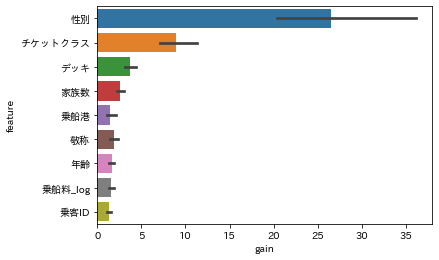

In [44]:
sns.barplot(x='gain',y='feature',data=importances.sort_values('gain',ascending=False))


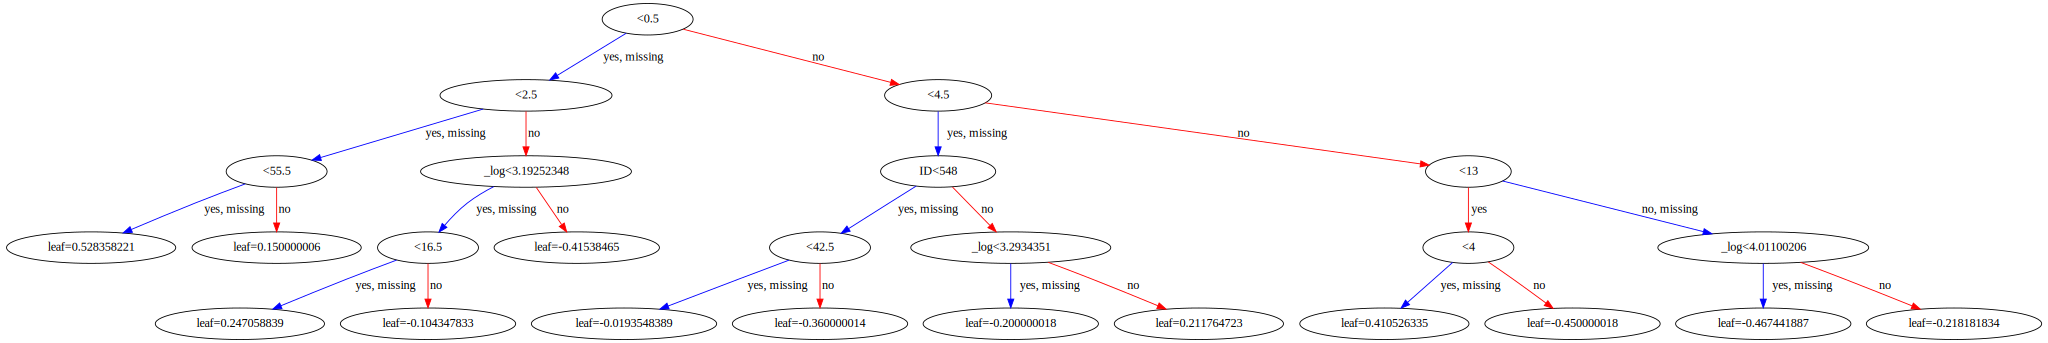

In [45]:
xgb.to_graphviz(model)

In [46]:
#predictで予測
dtest = xgb.DMatrix(test)
y_pred_proba = model.predict(dtest)
y_pred_proba

array([0.10867575, 0.28314683, 0.14548995, 0.18006252, 0.2939142 ,
       0.08902602, 0.17505513, 0.06796385, 0.7906859 , 0.06796385,
       0.06388015, 0.12375586, 0.9673052 , 0.14768781, 0.9629381 ,
       0.9713102 , 0.13869   , 0.40353206, 0.2595711 , 0.52027494,
       0.3431088 , 0.12087822, 0.96080494, 0.4107126 , 0.95567214,
       0.06954084, 0.985036  , 0.40353206, 0.7095472 , 0.2380218 ,
       0.09285975, 0.07688028, 0.37819564, 0.1748242 , 0.8280544 ,
       0.2611847 , 0.240688  , 0.10763616, 0.07877138, 0.17281707,
       0.12648071, 0.53692204, 0.09315269, 0.9286798 , 0.98183364,
       0.12278686, 0.6685342 , 0.15558182, 0.95946676, 0.39315683,
       0.576468  , 0.30594766, 0.74509066, 0.8543358 , 0.2760326 ,
       0.02453087, 0.09315269, 0.09796125, 0.06605078, 0.9817155 ,
       0.06033537, 0.21892658, 0.0761261 , 0.4365313 , 0.28655794,
       0.84317905, 0.43002287, 0.12019163, 0.701421  , 0.74055254,
       0.3863748 , 0.07545388, 0.26646265, 0.86949104, 0.98525

In [47]:
#predictで予測
dtest = xgb.DMatrix(test)
y_pred_proba = model.predict(dtest)
y_pred= np.where(y_pred_proba > 0.5,1,0)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':test['乗客ID'], 'Survived':y_pred})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# Optunaでのハイパーパラメータチューニング

In [48]:
trn_x, trn_y = X_train.iloc[cv[0][0]],y_train[cv[0][0]]

trn_x.head(10)

,乗客ID,チケットクラス,性別,年齢,乗船港,デッキ,家族数,乗船料_log,敬称
0,1,3,1,22.0,2,8,1,2.110213,12
1,2,1,0,38.0,0,2,1,4.280593,13
2,3,3,0,26.0,2,8,0,2.188856,9
3,4,1,0,35.0,2,2,1,3.990834,13
5,6,3,1,NaN,1,8,0,2.246893,12
7,8,3,1,2.0,2,8,4,3.094446,8
8,9,3,0,27.0,2,8,2,2.495954,13
9,10,2,0,14.0,0,8,1,3.436268,13
10,11,3,0,4.0,2,6,2,2.873565,9
11,12,1,0,58.0,2,2,0,3.316003,9


In [49]:
trn_y.head(10)

0     0
1     1
2     1
3     1
5     0
7     0
8     1
9     1
10    1
11    1
Name: 生死, dtype: int64

In [50]:
import optuna # ハイパーパラメーターのチューニングのため
from xgboost import XGBClassifier

def run(trial):
    params = {
    "objective":"binary:logistic",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "eval_metoric":"logloss",# テストデータに対する評価指標
    #"max_depth":4,
    "random_state":42,
    "verbosity":0,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
    "silent":1 # 0:起動中のメッセージを出力
    }
    fold = 0
    # 各ハイパーパラメーターの提案値を取得
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 0.3, log=True)
    #reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 100.0)
    #reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 100.0)
    #subsample = trial.suggest_float('subsample', 0.1, 1.0)
    #colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    max_depth = trial.suggest_int('max_depth', 2, 6)
    
    trn_x, trn_y = X_train.iloc[cv[fold][0]],y_train[cv[fold][0]]
    val_x, val_y = X_train.iloc[cv[fold][1]],y_train[cv[fold][1]]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = xgb.DMatrix(trn_x, label=trn_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)
    
    
    model=XGBClassifier(
        eval_metric="logloss",
        n_estimators=NROUND, # 早期停止（Early Stopping）するのでチューニングは不要
        # 定義したチューニング対象を各ハイパーパラメーターの引数に指定
        #subsample=subsample,
        #colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        max_depth=max_depth)
    
    model.fit(
    trn_x, trn_y,
    early_stopping_rounds=ESR, 
    eval_set=[(val_x, val_y)], # 早期停止するため検証データも指定
    verbose=1000) # 1000個目のestimatorsごとに出力
    '''
    #モデルのfit
    model = xgb.train(
        params,
        dtrain = dtrain,
        num_boost_round = NROUND,
        evals=[(dtrain,"train"),(dvalid,"valid")],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL,
        # 定義したチューニング対象を各ハイパーパラメーターの引数に指定
        max_depth = max_depth,
        learning_rate = learning_rate
    )
    '''
    # 検証データをモデルに入力して予測する
    val_preds = model.predict(val_x, ntree_limit=model.best_ntree_limit)
    
    #foldのvalのlogloss(スコア)算出
    logloss = log_loss(val_y,val_preds)
    
    #この評価値に基づき、
    #Optunaがハイパーパラメーターを自動的にチューニングしてくれる仕組み
    return logloss
                                

In [51]:
# https://qiita.com/c60evaporator/items/633575c37863d1d18335
## 乱数シードの固定
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

#run()関数を5回呼び出しながら各ハイパーパラメーターを最適化
#5回は少ないので、本来は500回などもう少し多い回数を指定するとよい
#study.optimize(run, n_trials=5)

study.optimize(run, n_trials=100)

[I 2022-11-29 20:13:44,284] A new study created in memory with name: no-name-f01e04a0-f217-4433-873c-a73a6b3a5907


[0]	validation_0-logloss:0.67652
[144]	validation_0-logloss:0.36738


[I 2022-11-29 20:13:44,871] Trial 0 finished with value: 4.823887188001166 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 6}. Best is trial 0 with value: 4.823887188001166.


[0]	validation_0-logloss:0.63908
[42]	validation_0-logloss:0.39253


[I 2022-11-29 20:13:45,064] Trial 1 finished with value: 5.595716821363921 and parameters: {'learning_rate': 0.1205712628744377, 'max_depth': 4}. Best is trial 0 with value: 4.823887188001166.


[0]	validation_0-logloss:0.68583
[738]	validation_0-logloss:0.37166


[I 2022-11-29 20:13:47,318] Trial 2 finished with value: 5.595721288388671 and parameters: {'learning_rate': 0.01700037298921102, 'max_depth': 2}. Best is trial 0 with value: 4.823887188001166.


[0]	validation_0-logloss:0.68741
[410]	validation_0-logloss:0.36678


[I 2022-11-29 20:13:49,577] Trial 3 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.012184186502221764, 'max_depth': 6}. Best is trial 0 with value: 4.823887188001166.


[0]	validation_0-logloss:0.65687
[133]	validation_0-logloss:0.37016


[I 2022-11-29 20:13:50,050] Trial 4 finished with value: 5.402762763291795 and parameters: {'learning_rate': 0.07725378389307355, 'max_depth': 5}. Best is trial 0 with value: 4.823887188001166.


[0]	validation_0-logloss:0.68809
[458]	validation_0-logloss:0.36696


[I 2022-11-29 20:13:51,732] Trial 5 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.010725209743171997, 'max_depth': 6}. Best is trial 0 with value: 4.823887188001166.


[0]	validation_0-logloss:0.62109
[108]	validation_0-logloss:0.36574


[I 2022-11-29 20:13:52,097] Trial 6 finished with value: 4.630933129929039 and parameters: {'learning_rate': 0.16967533607196555, 'max_depth': 3}. Best is trial 6 with value: 4.630933129929039.


[0]	validation_0-logloss:0.68516
[657]	validation_0-logloss:0.37143


[I 2022-11-29 20:13:54,240] Trial 7 finished with value: 5.595721288388671 and parameters: {'learning_rate': 0.01855998084649059, 'max_depth': 2}. Best is trial 6 with value: 4.630933129929039.


[0]	validation_0-logloss:0.67991
[139]	validation_0-logloss:0.38805


[I 2022-11-29 20:13:54,752] Trial 8 finished with value: 5.016850180122791 and parameters: {'learning_rate': 0.028145092716060652, 'max_depth': 4}. Best is trial 6 with value: 4.630933129929039.


[0]	validation_0-logloss:0.67344
[254]	validation_0-logloss:0.37105


[I 2022-11-29 20:13:55,642] Trial 9 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.04345454109729477, 'max_depth': 3}. Best is trial 6 with value: 4.630933129929039.


[0]	validation_0-logloss:0.58174
[102]	validation_0-logloss:0.36381


[I 2022-11-29 20:13:55,997] Trial 10 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.27836766598915424, 'max_depth': 3}. Best is trial 6 with value: 4.630933129929039.


[0]	validation_0-logloss:0.60486
[59]	validation_0-logloss:0.37778


[I 2022-11-29 20:13:56,242] Trial 11 finished with value: 5.595712354339172 and parameters: {'learning_rate': 0.20162663208856213, 'max_depth': 5}. Best is trial 6 with value: 4.630933129929039.


[0]	validation_0-logloss:0.66511
[277]	validation_0-logloss:0.36935


[I 2022-11-29 20:13:57,164] Trial 12 finished with value: 4.437974604832163 and parameters: {'learning_rate': 0.06242660988477502, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65426
[116]	validation_0-logloss:0.37286


[I 2022-11-29 20:13:57,578] Trial 13 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.08772140066845575, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63127
[112]	validation_0-logloss:0.36237


[I 2022-11-29 20:13:57,980] Trial 14 finished with value: 4.823887188001165 and parameters: {'learning_rate': 0.1437195898802834, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66936
[223]	validation_0-logloss:0.37141


[I 2022-11-29 20:13:58,733] Trial 15 finished with value: 5.209813172244418 and parameters: {'learning_rate': 0.0563499158561632, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62650
[44]	validation_0-logloss:0.38643


[I 2022-11-29 20:13:58,928] Trial 16 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.15105812997121754, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.57658
[52]	validation_0-logloss:0.36431


[I 2022-11-29 20:13:59,131] Trial 17 finished with value: 4.437979071856912 and parameters: {'learning_rate': 0.2937683775461304, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.57414
[60]	validation_0-logloss:0.36855


[I 2022-11-29 20:13:59,351] Trial 18 finished with value: 4.437979071856912 and parameters: {'learning_rate': 0.2914574140779848, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65858
[85]	validation_0-logloss:0.37374


[I 2022-11-29 20:13:59,683] Trial 19 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.07346447050057535, 'max_depth': 5}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64901
[167]	validation_0-logloss:0.36781


[I 2022-11-29 20:14:00,233] Trial 20 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.10730266434120375, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.57202
[55]	validation_0-logloss:0.38200


[I 2022-11-29 20:14:00,451] Trial 21 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.29769379410677543, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59824
[65]	validation_0-logloss:0.38454


[I 2022-11-29 20:14:00,712] Trial 22 finished with value: 5.209813172244417 and parameters: {'learning_rate': 0.22378823294320763, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59955
[43]	validation_0-logloss:0.37580


[I 2022-11-29 20:14:00,891] Trial 23 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.227371046399541, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66678
[97]	validation_0-logloss:0.38894


[I 2022-11-29 20:14:01,272] Trial 24 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.056885602969300085, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.57474
[64]	validation_0-logloss:0.37236


[I 2022-11-29 20:14:01,519] Trial 25 finished with value: 5.016850180122791 and parameters: {'learning_rate': 0.29935016322417496, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68009
[177]	validation_0-logloss:0.38140


[I 2022-11-29 20:14:02,213] Trial 26 finished with value: 5.20979530414542 and parameters: {'learning_rate': 0.027074438914697734, 'max_depth': 5}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61448
[75]	validation_0-logloss:0.36907


[I 2022-11-29 20:14:02,513] Trial 27 finished with value: 4.630937596953788 and parameters: {'learning_rate': 0.18696193737064482, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63945
[54]	validation_0-logloss:0.38812


[I 2022-11-29 20:14:02,750] Trial 28 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.1196890828618731, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67658
[328]	validation_0-logloss:0.37188


[I 2022-11-29 20:14:03,812] Trial 29 finished with value: 5.595721288388671 and parameters: {'learning_rate': 0.03889408796901487, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65160
[147]	validation_0-logloss:0.36780


[I 2022-11-29 20:14:04,323] Trial 30 finished with value: 4.630928662904289 and parameters: {'learning_rate': 0.09402151306510112, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66317
[256]	validation_0-logloss:0.36501


[I 2022-11-29 20:14:05,267] Trial 31 finished with value: 4.437974604832163 and parameters: {'learning_rate': 0.06689802001564374, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66289
[157]	validation_0-logloss:0.37496


[I 2022-11-29 20:14:05,829] Trial 32 finished with value: 5.016850180122791 and parameters: {'learning_rate': 0.0675600501216125, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67789
[152]	validation_0-logloss:0.38761


[I 2022-11-29 20:14:06,382] Trial 33 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.032512271902578035, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67481
[315]	validation_0-logloss:0.37119


[I 2022-11-29 20:14:07,415] Trial 34 finished with value: 5.595721288388671 and parameters: {'learning_rate': 0.04314829903118142, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68495
[241]	validation_0-logloss:0.38715


[I 2022-11-29 20:14:08,274] Trial 35 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.017331283623495463, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63552
[144]	validation_0-logloss:0.36200


[I 2022-11-29 20:14:08,779] Trial 36 finished with value: 4.630937596953788 and parameters: {'learning_rate': 0.13310036903004113, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59017
[33]	validation_0-logloss:0.38699


[I 2022-11-29 20:14:08,933] Trial 37 finished with value: 5.595707887314423 and parameters: {'learning_rate': 0.2405940176996762, 'max_depth': 5}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62409
[108]	validation_0-logloss:0.36851


[I 2022-11-29 20:14:09,300] Trial 38 finished with value: 5.595712354339172 and parameters: {'learning_rate': 0.17382062178166283, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68200
[212]	validation_0-logloss:0.36886


[I 2022-11-29 20:14:10,132] Trial 39 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.023809496863824855, 'max_depth': 6}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66978
[141]	validation_0-logloss:0.37654


[I 2022-11-29 20:14:10,620] Trial 40 finished with value: 5.016850180122791 and parameters: {'learning_rate': 0.05174389051177947, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65188
[187]	validation_0-logloss:0.36499


[I 2022-11-29 20:14:11,245] Trial 41 finished with value: 4.437979071856912 and parameters: {'learning_rate': 0.0933518763113643, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65416
[112]	validation_0-logloss:0.37474


[I 2022-11-29 20:14:11,656] Trial 42 finished with value: 5.016850180122791 and parameters: {'learning_rate': 0.0879541220135037, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66527
[160]	validation_0-logloss:0.37148


[I 2022-11-29 20:14:12,217] Trial 43 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.062074180147617716, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67215
[290]	validation_0-logloss:0.37207


[I 2022-11-29 20:14:13,185] Trial 44 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.049558678535305906, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64703
[190]	validation_0-logloss:0.35862


[I 2022-11-29 20:14:13,815] Trial 45 finished with value: 4.437979071856912 and parameters: {'learning_rate': 0.10495057945680361, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64681
[152]	validation_0-logloss:0.38029


[I 2022-11-29 20:14:14,377] Trial 46 finished with value: 5.209813172244417 and parameters: {'learning_rate': 0.10234639270077729, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65675
[146]	validation_0-logloss:0.37383


[I 2022-11-29 20:14:14,907] Trial 47 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.08185329724712348, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64105
[50]	validation_0-logloss:0.38703


[I 2022-11-29 20:14:15,126] Trial 48 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.11589094098617353, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59326
[66]	validation_0-logloss:0.36865


[I 2022-11-29 20:14:15,377] Trial 49 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.2640135985499121, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65923
[100]	validation_0-logloss:0.37644


[I 2022-11-29 20:14:15,739] Trial 50 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.07605549420270569, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66363
[206]	validation_0-logloss:0.37203


[I 2022-11-29 20:14:16,525] Trial 51 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.06583908734228167, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62586
[140]	validation_0-logloss:0.36229


[I 2022-11-29 20:14:16,993] Trial 52 finished with value: 4.630937596953789 and parameters: {'learning_rate': 0.1574232076938252, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60793
[58]	validation_0-logloss:0.37060


[I 2022-11-29 20:14:17,227] Trial 53 finished with value: 4.630933129929039 and parameters: {'learning_rate': 0.20444893506407058, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63463
[109]	validation_0-logloss:0.36948


[I 2022-11-29 20:14:17,616] Trial 54 finished with value: 4.63093312992904 and parameters: {'learning_rate': 0.1353189049223627, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64678
[169]	validation_0-logloss:0.37799


[I 2022-11-29 20:14:18,190] Trial 55 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.10241098036094519, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.58996
[95]	validation_0-logloss:0.36822


[I 2022-11-29 20:14:18,515] Trial 56 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.2544230803669991, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67288
[253]	validation_0-logloss:0.37166


[I 2022-11-29 20:14:20,086] Trial 57 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.04472421891867587, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66014
[91]	validation_0-logloss:0.36729


[I 2022-11-29 20:14:20,457] Trial 58 finished with value: 4.823887188001166 and parameters: {'learning_rate': 0.07243543308848907, 'max_depth': 6}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66851
[254]	validation_0-logloss:0.37141


[I 2022-11-29 20:14:21,284] Trial 59 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.058406016994124406, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65266
[76]	validation_0-logloss:0.38604


[I 2022-11-29 20:14:21,583] Trial 60 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.08879225285600434, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65492
[184]	validation_0-logloss:0.36974


[I 2022-11-29 20:14:22,244] Trial 61 finished with value: 4.823891655025916 and parameters: {'learning_rate': 0.08616722609751429, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65058
[136]	validation_0-logloss:0.37061


[I 2022-11-29 20:14:22,711] Trial 62 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.09646133504532514, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68826
[591]	validation_0-logloss:0.37672


[I 2022-11-29 20:14:24,715] Trial 63 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.010608169900193873, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60894
[76]	validation_0-logloss:0.36958


[I 2022-11-29 20:14:25,011] Trial 64 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.20173369602266195, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64068
[68]	validation_0-logloss:0.37338


[I 2022-11-29 20:14:25,270] Trial 65 finished with value: 4.630937596953789 and parameters: {'learning_rate': 0.12037791892154152, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66155
[64]	validation_0-logloss:0.38913


[I 2022-11-29 20:14:25,524] Trial 66 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.06857222943509236, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62620
[105]	validation_0-logloss:0.36912


[I 2022-11-29 20:14:25,876] Trial 67 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.16799414240825547, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67737
[309]	validation_0-logloss:0.37282


[I 2022-11-29 20:14:26,893] Trial 68 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.03463785313562863, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60100
[125]	validation_0-logloss:0.36197


[I 2022-11-29 20:14:27,378] Trial 69 finished with value: 4.630933129929039 and parameters: {'learning_rate': 0.22336876549869739, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68628
[339]	validation_0-logloss:0.38122


[I 2022-11-29 20:14:28,598] Trial 70 finished with value: 5.20979530414542 and parameters: {'learning_rate': 0.014136833236025171, 'max_depth': 5}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61116
[54]	validation_0-logloss:0.36859


[I 2022-11-29 20:14:28,816] Trial 71 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.1957800574545361, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60118
[54]	validation_0-logloss:0.37123


[I 2022-11-29 20:14:29,030] Trial 72 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.22286940717093104, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64468
[161]	validation_0-logloss:0.36551


[I 2022-11-29 20:14:29,566] Trial 73 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.11064227355116107, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.58989
[83]	validation_0-logloss:0.36830


[I 2022-11-29 20:14:29,859] Trial 74 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.27453536166047343, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63576
[164]	validation_0-logloss:0.36549


[I 2022-11-29 20:14:30,401] Trial 75 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.13249643349689488, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65027
[80]	validation_0-logloss:0.38902


[I 2022-11-29 20:14:30,692] Trial 76 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.09430704183860573, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.57677
[46]	validation_0-logloss:0.36949


[I 2022-11-29 20:14:30,873] Trial 77 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.29320307893357034, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59375
[68]	validation_0-logloss:0.36873


[I 2022-11-29 20:14:31,131] Trial 78 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.2436104099724157, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65769
[133]	validation_0-logloss:0.37308


[I 2022-11-29 20:14:31,590] Trial 79 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.07966262701402013, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61433
[37]	validation_0-logloss:0.39342


[I 2022-11-29 20:14:31,758] Trial 80 finished with value: 5.209799771170169 and parameters: {'learning_rate': 0.18160099578722083, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62659
[73]	validation_0-logloss:0.36949


[I 2022-11-29 20:14:32,036] Trial 81 finished with value: 4.630928662904289 and parameters: {'learning_rate': 0.1555508879138753, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62513
[204]	validation_0-logloss:0.35657


[I 2022-11-29 20:14:32,716] Trial 82 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.15928386018263643, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62944
[55]	validation_0-logloss:0.37773


[I 2022-11-29 20:14:32,929] Trial 83 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.14831711760737204, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63573
[129]	validation_0-logloss:0.37123


[I 2022-11-29 20:14:33,384] Trial 84 finished with value: 4.437974604832163 and parameters: {'learning_rate': 0.1325733111151346, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63818
[124]	validation_0-logloss:0.36586


[I 2022-11-29 20:14:33,809] Trial 85 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.12652216910144923, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66568
[192]	validation_0-logloss:0.37210


[I 2022-11-29 20:14:34,454] Trial 86 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.06112677831656808, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64612
[128]	validation_0-logloss:0.37430


[I 2022-11-29 20:14:34,920] Trial 87 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.1071431568540031, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67148
[148]	validation_0-logloss:0.37490


[I 2022-11-29 20:14:35,451] Trial 88 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.047885194288274466, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63639
[131]	validation_0-logloss:0.36886


[I 2022-11-29 20:14:35,907] Trial 89 finished with value: 5.595716821363922 and parameters: {'learning_rate': 0.1403513549064411, 'max_depth': 2}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65908
[63]	validation_0-logloss:0.38646


[I 2022-11-29 20:14:36,165] Trial 90 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.07416352896034396, 'max_depth': 4}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66896
[164]	validation_0-logloss:0.37235


[I 2022-11-29 20:14:36,751] Trial 91 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.053628144320018195, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60666
[109]	validation_0-logloss:0.36416


[I 2022-11-29 20:14:37,143] Trial 92 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.20788753163900864, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.65141
[124]	validation_0-logloss:0.37122


[I 2022-11-29 20:14:37,576] Trial 93 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.09448739855468065, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59427
[90]	validation_0-logloss:0.36620


[I 2022-11-29 20:14:37,939] Trial 94 finished with value: 4.630937596953788 and parameters: {'learning_rate': 0.24215167260056739, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60407
[67]	validation_0-logloss:0.37861


[I 2022-11-29 20:14:38,205] Trial 95 finished with value: 5.788679813485548 and parameters: {'learning_rate': 0.21491507209843924, 'max_depth': 3}. Best is trial 12 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62092
[104]	validation_0-logloss:0.36659


[I 2022-11-29 20:14:38,569] Trial 96 finished with value: 4.245020546760036 and parameters: {'learning_rate': 0.1701201598656364, 'max_depth': 3}. Best is trial 96 with value: 4.245020546760036.


[0]	validation_0-logloss:0.63764
[113]	validation_0-logloss:0.36649


[I 2022-11-29 20:14:38,984] Trial 97 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.1278449994006889, 'max_depth': 3}. Best is trial 96 with value: 4.245020546760036.


[0]	validation_0-logloss:0.64364
[214]	validation_0-logloss:0.35701


[I 2022-11-29 20:14:39,711] Trial 98 finished with value: 4.437983538881662 and parameters: {'learning_rate': 0.11315808945559883, 'max_depth': 3}. Best is trial 96 with value: 4.245020546760036.


[0]	validation_0-logloss:0.64462
[157]	validation_0-logloss:0.36207


[I 2022-11-29 20:14:40,266] Trial 99 finished with value: 4.437979071856912 and parameters: {'learning_rate': 0.11078432396850432, 'max_depth': 3}. Best is trial 96 with value: 4.245020546760036.


In [52]:
study.best_params

{'learning_rate': 0.1701201598656364, 'max_depth': 3}

In [53]:
#パラメータについて: https://qiita.com/FJyusk56/items/0649f4362587261bd57a

params = {
    "objective":"binary:logistic",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "eval_metoric":"logloss",# テストデータに対する評価指標
    "max_depth":study.best_params["max_depth"],
    "learning_rate":study.best_params["learning_rate"],
    #"subsample":study.best_params["subsample"],
    #"colsample_bytree":study.best_params["colsample_bytree"],
    "random_state":42,
    "verbosity":0,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
    "silent":1 # 0:起動中のメッセージを出力
}

out_put_preds = np.zeros(len(y_train))

importances = pd.DataFrame()

#valのlogloss保存用
score_logloss = []

#valのaccuracy保存用
score_acc = []


# N Fold CVで学習
for i, (trn_idx, val_idx) in enumerate(cv):
    print(f'\nFold: {i} start prediction.')
    
    trn_x, trn_y = X_train.iloc[trn_idx],y_train[trn_idx]
    val_x, val_y = X_train.iloc[val_idx],y_train[val_idx]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = xgb.DMatrix(trn_x, label=trn_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)
    
    #モデルのfit
    model = xgb.train(
        params,
        dtrain = dtrain,
        num_boost_round = NROUND,
        evals=[(dtrain,"train"),(dvalid,"valid")],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL
    )
    
    # out of fold法を用いて訓練データの予測を行う
    val_preds = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    out_put_preds[val_idx] = val_preds
    
    #各foldのvalのloglossを保存
    logloss = log_loss(val_y,val_preds)
    score_logloss.append(logloss)
    
    val_pred_for_acc = np.where(val_preds >0.5,1,0)
    acc = accuracy_score(val_y,val_pred_for_acc)
    score_acc.append(acc)
    
    #各foldのimportanceを保存
    score_dict = model.get_score(importance_type="gain")
    imp_df = pd.DataFrame({
        "feature":list(score_dict.keys()),
        "gain":list(score_dict.values()),
        "fold":i
    }
    )
    importances = pd.concat([importances,imp_df],axis=0)
    
#各loglossのvalのloglossの平均をプリント
logloss = np.mean(score_logloss)

#各accuracyのvalのaccuracyの平均をプリント
accuracy = np.mean(score_acc)

print(f'val_loglss_mean: {logloss:.4f}')
print(f'val_accuracy_mean: {accuracy:.3f}')



Fold: 0 start prediction.
[0]	train-logloss:0.61954	valid-logloss:0.62092
[50]	train-logloss:0.30877	valid-logloss:0.37074
[100]	train-logloss:0.25037	valid-logloss:0.36803
[103]	train-logloss:0.24625	valid-logloss:0.36636

Fold: 1 start prediction.
[0]	train-logloss:0.61844	valid-logloss:0.62645
[50]	train-logloss:0.29742	valid-logloss:0.38812
[78]	train-logloss:0.25786	valid-logloss:0.39207

Fold: 2 start prediction.
[0]	train-logloss:0.61506	valid-logloss:0.62724
[37]	train-logloss:0.30335	valid-logloss:0.46479

Fold: 3 start prediction.
[0]	train-logloss:0.61899	valid-logloss:0.62288
[42]	train-logloss:0.31656	valid-logloss:0.40668

Fold: 4 start prediction.
[0]	train-logloss:0.61958	valid-logloss:0.62005
[37]	train-logloss:0.32005	valid-logloss:0.41303
val_loglss_mean: 0.4024
val_accuracy_mean: 0.830


In [54]:
#predictで予測
dtest = xgb.DMatrix(test)
y_pred_proba = model.predict(dtest)
y_pred= np.where(y_pred_proba > 0.5,1,0)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':test['乗客ID'], 'Survived':y_pred})
submission.to_csv('submission.csv', index=False)